<a href="https://colab.research.google.com/github/jeff547/pytorch-learning/blob/main/exercises/08_pytorch_paper_replicating_exercise/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
torch version: 2.7.0.dev20250127+cu118
torchvision version: 0.22.0.dev20250128+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    # !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\jeffl\Documents\GitHub\pytorch-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpi"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2a8d87b2e40>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

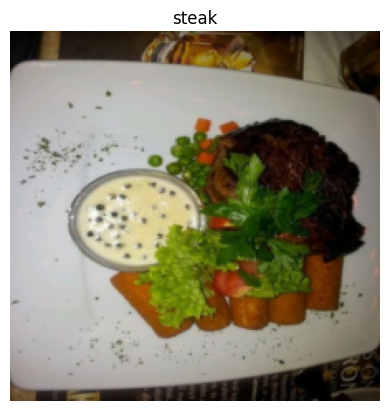

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [ ]:
%%writefile vit.py
import torch
from torch import nn

class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self, x):
    x = self.patcher(x)
    x = self.flatten(x)
    return x.permute(0,2,1)

class ViT(nn.Module):
  def __init__(self,
                img_size:int=224,
                in_channels:int=3,
                patch_size:int=16,
                num_transformers_layers:int=12,
                embedding_dim:int=768,
                mlp_size:int=3072,
                num_heads:int=12,
                mlp_dropout:float=0.1,
                embedding_dropout:float=0.1,
                num_classes:int=1000,):
    super().__init__()

    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

    self.num_patches = (img_size*img_size) // patch_size**2

    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

    self.position_embedding = nn.Parameter(data=torch.randn(1,self.num_patches+1, embedding_dim), requires_grad=True)

    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                    nhead=num_heads,
                                                    dropout=mlp_dropout,
                                                    dim_feedforward=mlp_size,
                                                    )

    self.transform_encoder = nn.TransformerEncoder(self.encoder_layer,
                                                   num_layers=num_transformers_layers)

    self.classifer = nn.Sequential(
      nn.LayerNorm(normalized_shape=embedding_dim),
      nn.Linear(in_features=embedding_dim,
                out_features=num_classes)
    )

  def forward(self, x):
    BATCH_SIZE = x.shape[0]

    class_token = self.class_embedding.expand(BATCH_SIZE, -1, -1)

    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transform_encoder(x)
    x = self.classifer(x[:,0])
    return x

Overwriting vit.py


In [ ]:
random_img_tensor = torch.randn(1, 3, 224, 224).to(device)
vit = ViT(num_classes=len(class_names)).to(device)
vit(random_img_tensor)

NameError: name 'ViT' is not defined

In [ ]:
from torchinfo import summary

summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

NameError: name 'vit' is not defined

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


In [ ]:
!python vit.py

In [ ]:
from vit import ViT
vit = ViT(num_classes=3)
summary(model=vit,
        input_size=(1,3,224,224),
        )

c:\Users\jeffl\Documents\GitHub\pytorch-learning\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    7,239,936
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [ ]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
pretrained_vit_transforms = pretrained_vit_weights.transforms()

for param in pretrained_vit.parameters():
  param.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32,)

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# TODO: your code
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(pretrained_vit,
                       train_dataloader_pretrained,
                       test_dataloader_pretrained,
                       optimizer,
                       loss_fn,
                       10,
                       device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [ ]:
# TODO: your code
pretrained_vit_weights_V2 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit_V2 = torchvision.models.vit_b_16(weights=pretrained_vit_weights_V2).to(device)
pretrained_vit_transforms_V2 = pretrained_vit_weights_V2.transforms()

for param in pretrained_vit_V2.parameters():
  param.requires_grad = False

pretrained_vit_V2.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [ ]:
train_dataloader_pretrained_V2, test_dataloader_pretrained_V2, class_names_V2 = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms_V2,
                                                                                                     batch_size=32,)

In [ ]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=pretrained_vit_V2.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results_v2 = engine.train(model=pretrained_vit_V2,
                                         train_dataloader=train_dataloader_pretrained_V2,
                                         test_dataloader=test_dataloader_pretrained_V2,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=5,
                                         device=device)

  0%|          | 0/10 [00:06<?, ?it/s]


KeyboardInterrupt: 

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

In [ ]:
# TODO: your explanations of the above terms